In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import genpareto, norm
import math

In [2]:
np.warnings.filterwarnings('ignore')

In [3]:
prices = pd.read_csv('datasource/AXP Historical Data.csv')

In [4]:
prices['Date'] = prices['Date'].apply(lambda x: datetime.datetime.strptime(x,'%b %d, %Y'))
prices.sort_values(['Date'], inplace=True)
prices.reset_index(drop=True, inplace=True)

In [5]:
prices['return'] = prices['Price'].pct_change() * 100

# American Express returns histogram

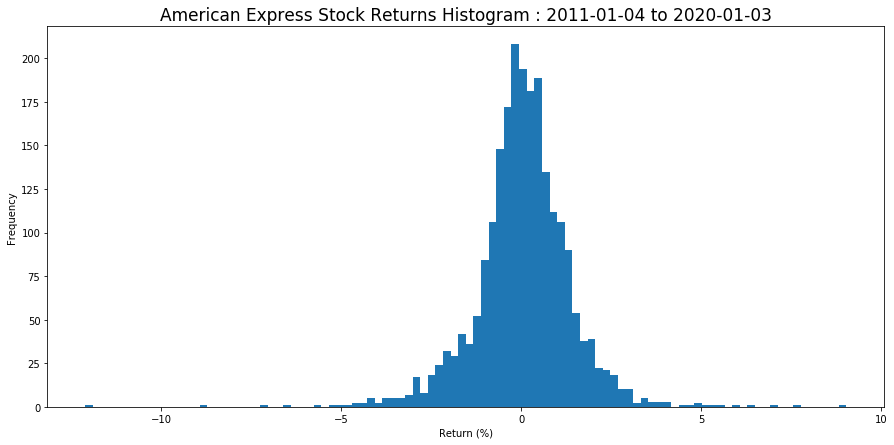

In [6]:
plt.figure(figsize=(15,7))
plt.hist(prices['return'], bins=100)
plt.title(
    'American Express Stock Returns Histogram : '+
    min(prices['Date']).date().strftime('%Y-%m-%d')+
    ' to '+
    max(prices['Date']).date().strftime('%Y-%m-%d'),
    fontsize=17
)
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.show()

In [7]:
print('Mean\t\t : ',prices['return'].mean())
print('Variance\t : ',prices['return'].var())
print('Skewness\t : ',prices['return'].skew())
print('Kurtosis\t : ',prices['return'].kurtosis())

Mean		 :  0.05507091359887325
Variance	 :  1.8006052702755442
Skewness	 :  -0.3857569777177754
Kurtosis	 :  7.120513770330035


# Cornish y Fisher

The Cornish and Fisher expansion is, as we can see in this <a href="https://www.riskconcile.com/wp-content/uploads/2020/03/cornish_fisher.html">webpage</a>, <i>"an asymptotic expansion used to approximate the quantiles of a probability distribution based on its moments"</i>. Basically this expansion does allow to get percentiles from non-normal distributions applying a closed form formula, using the first 4 moments, such as: mean, variance, skewness and excess kurtosis.

About C-F anatomy, we can see <a href="https://www.riskconcile.com/wp-content/uploads/2020/03/cornish_fisher_2.html">this</a>, where with:

* $Z_{CF,\alpha}$ the Cornish Fisher Z
* $Z_{\alpha}$ where $Z_{\alpha} \thicksim N(0,1)$
* $S$, the skewness coefficient
* $K$, the excess coefficient

$Z_{CF,\alpha} = Z_{\alpha} + \frac{1}{6}(Z_{\alpha}^2-1)S + \frac{1}{24}(Z_{\alpha}^3-3Z_{\alpha})K - \frac{1}{36}(2Z_{\alpha}^3-5Z_{\alpha})S^2$

In [8]:
Z_CF = lambda S, K, Z_alpha: Z_alpha + \
                            (1/6)*(Z_alpha**2-1)*S+\
                            (1/24)*(Z_alpha**3-3*Z_alpha)*K-\
                            (1/36)*(2*Z_alpha**3-5*Z_alpha)*S**2

A very important issue about the formula above, is $S$ and $K$ are not the actual skewness and excess kurtosis, or observed. This parameters must be calculated. In this way, some authos like <a href='https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1997178'>(Maillard, D. 2018)</a> and <a href="https://link.springer.com/article/10.1007%2Fs10479-018-2792-4">(Amédée, C & Barthélémy, F & Maillard, D. 2018)</a> did show some values, the first one, and a method, the second one, in their articles.

In Amédée, et. al (2018) article, they resolved the $S$ and $K$ coefficient following the RSM (Response Surface Methodology), given as result this:

$
K = −5.963 + 21.52S_o^{\frac{1}{2}} − 1.548 K_o^{\frac{1}{2}} − 26.52 S_o + 1.820 K_o + 11.08 S_o^{\frac{3}{2}} − 0.442 K_o^{\frac{3}{2}}\\
\hspace{1cm}− 2.564 S_o^{\frac{1}{2}} K_o + 5.740 S_o K_o^{\frac{1}{2}} + 0.342 S_o^2 + 0.0016 K_o^2 + 0.880 S_o K_o\\
\hspace{1cm}− 3.773 S_o^{\frac{3}{2}} K_o^{\frac{1}{2}} + 0.033 S_o^{\frac{1}{2}} K_o^{\frac{3}{2}} + 0.001 S_o K_o^2 + 0.072 S_o^2 K_o − 0.021 S_o^{\frac{3}{2}} K_o^{\frac{3}{2}}\\
\hspace{1cm}− 0.721 ln(S_o) ln(K_o) + 0.349 ln(S_o) K_o + 0.366 S_o ln(K_o) + 0.366 S_o^{-1} − 0.555 K_o^{-1}\\
$

$
S = −1.816 + 6.812 S_o^{\frac{1}{2}} − 0.577K_o^{\frac{1}{2}} − 8.635S_o + 0.508K_o + 4.235S_o^{\frac{3}{2}} − 0.007K_o^{\frac{3}{2}}\\
\hspace{1cm}− 0.848S_o^{\frac{1}{2}}K_o + 2.671S_oK_o^{\frac{1}{2}} − 0.097S_o^2 − 0.0003K_o^2 + 0.225 S_oK_o\\
\hspace{1cm}− 1.258S_o^{\frac{3}{2}}K_o^{\frac{1}{2}} + 0.019 S_o^{\frac{1}{2}}K_o^{\frac{3}{2}} + 0.0002S_oK_o^2 + 0.025S_o^2K_o − 0.0067 S_o^{\frac{3}{2}}K_o^{\frac{3}{2}}\\
\hspace{1cm}− 0.105ln(S_o) ln(K_o) + 0.098 ln(S_o)K_o − 0.845S_oln(K_o) + 0.134S_o^{-1} − 0.416 K_o^{-1}
$

With $S_o$ and $K_o$ as skewness and excess return observed.

In [9]:
S_o = prices['return'].skew() * np.sign(prices['return'].skew())
K_o = prices['return'].kurtosis()
print(S_o)
print(K_o)

0.3857569777177754
7.120513770330035


In [10]:
coeffs = np.array([
    1, math.sqrt(S_o), math.sqrt(K_o), S_o, K_o, S_o**(3/2), K_o**(3/2), math.sqrt(S_o)*K_o,
    math.sqrt(K_o)*S_o, S_o**2, K_o**2, S_o*K_o, (S_o**(3/2))*math.sqrt(K_o), (K_o**(3/2))*math.sqrt(S_o),
    S_o*(K_o**2), (S_o**2)*K_o,(S_o**(3/2))*(K_o**(3/2)),math.log(S_o)*math.log(K_o),
    math.log(S_o)*K_o, S_o*math.log(K_o), 1/S_o, 1/K_o
])

In [11]:
K_val = np.array([
    -5.963, 21.52, -1.548, -26.52, 1.820, 11.08, -0.442, -2.564,
    5.740, 0.342, 0.0016,0.880, -3.773, 0.033, 0.001, 0.072,
    -0.021,-0.721, 0.349, 0.366, 0.366, -0.555
])

In [12]:
S_val = np.array([
    -1.816, 6.812, -0.577, -8.635, 0.508, 4.235, -0.007,
    -0.848, 2.671, -0.097, -0.0003, 0.225,-1.258, 0.019,
    0.0002, 0.025, -0.0067,-0.105, 0.098, -0.845, 0.134, -0.416
])

In [13]:
K_CF = K_val @ coeffs.T
S_CF = S_val @ coeffs.T
print(K_CF)
print(S_CF)

-4.517397445678776
0.23117313776444665


One problem is raised when we use this approach. It is the $K_{CF}$, because result is negative and far away from Maillard's K value. For this reason, we choose the numbers given by Maillard (2012) in him Appendix 2.

In [14]:
K_CF = 2.796
S_CF = 0.234
alpha = 0.01

In [15]:
Z_CF_v = Z_CF(S_CF, K_CF , norm.ppf(alpha))
Z_CF_v

-2.7873477303007497

Now, we need to calculate $VaR_{CF,\alpha}$ as:

$VaR_{CF,\alpha} = \mu + Z_{CF,\alpha} \sigma_{CF}$

where $\sigma_{CF}$, following (Amédée, C & Barthélémy, F & Maillard, D. 2018) is:

$\sigma_{CF} = \frac{\sigma}{\sqrt{
1+\frac{1}{96}K^2+\frac{25}{1296}S^4-\frac{1}{36}KS^2
}}$

In [16]:
sigma_CF = prices['return'].std()/math.sqrt(1+(1/96)*(K_CF**2)+(25/1296)*(S_CF**4)-(1/36)*K_CF*(S_CF**2))

In [17]:
VaR_CF = prices['return'].mean() + Z_CF_v*sigma_CF

In [18]:
VaR_CF

-3.5485944261962876

In [19]:
VaR_CF_test = pd.DataFrame(columns=['significance_level', 'var_CF'])
for significance_i in np.arange(0.005,0.07,0.005).tolist():
    Z_CF_v = Z_CF(S_CF, K_CF , norm.ppf(significance_i))
    VaR_CF_test.loc[len(VaR_CF_test)] = [significance_i, -(prices['return'].mean() + Z_CF_v*sigma_CF)]
    del Z_CF_v

In [20]:
VaR_CF_test

,significance_level,var_CF
0,0.005,4.359345
1,0.010,3.548594
2,0.015,3.103372
3,0.020,2.800755
4,0.025,2.573692
5,0.030,2.393161
6,0.035,2.244030
7,0.040,2.117439
8,0.045,2.007765
9,0.050,1.911227


# Comparison EVT and Parametric VaR
The EVT and Parametric VaR to AXP was develop in this <a href="https://github.com/craquinterogo/quantitative_finance/blob/master/Risk/Market/VaR/EVT_ExtremeValueTheory.ipynb">link</a>

.. loading that results here ..

In [21]:
results_EVT = pd.read_csv('datasource/results/EVT/evt_results.csv')

In [22]:
results_EVT.rename(columns={'differences':'diff_evt_param'}, inplace=True)

In [23]:
results = results_EVT.merge(
            VaR_CF_test,
            on='significance_level'
            )
del results_EVT

In [24]:
results['diff_cf_param'] = results['var_CF'] - results['var_parametric']
results['diff_cf_evt'] = results['var_CF'] - results['var_evt']

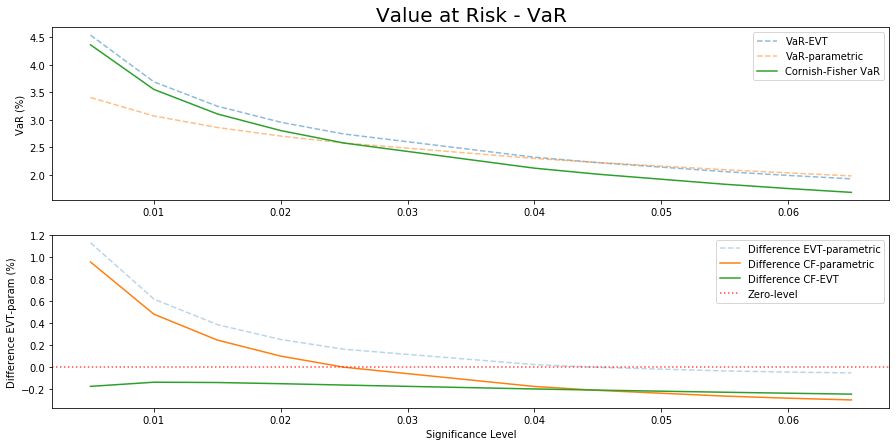

In [25]:
plt.figure(figsize=(15,7))

plt.subplot(2,1,1)
plt.plot(results['significance_level'], results['var_evt'], label='VaR-EVT', linestyle='dashed', alpha=0.5)
plt.plot(results['significance_level'], results['var_parametric'], label='VaR-parametric', linestyle='dashed', alpha=0.5)
plt.plot(results['significance_level'], results['var_CF'], label='Cornish-Fisher VaR')
plt.title('Value at Risk - VaR', fontsize=20)
plt.ylabel('VaR (%)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(results['significance_level'], results['diff_evt_param'], label='Difference EVT-parametric', linestyle='dashed', alpha=0.3)
plt.plot(results['significance_level'], results['diff_cf_param'], label='Difference CF-parametric')
plt.plot(results['significance_level'], results['diff_cf_evt'], label='Difference CF-EVT')
plt.axhline(y=0, color='r', linestyle='dotted', alpha=0.7, label='Zero-level')
plt.ylabel('Difference EVT-param (%)')
plt.xlabel('Significance Level')
plt.legend()

plt.show()

# Conclusion

The way given by Amédée was applied but the results did not have the answer to our $S$ and $K$ coefficients. Beside this, the Maillard table did give a $S$ and $K$ coefficient values which to help to calculate $Z_{CF,\alpha}$, but until now is not clear the mechanism as he did solve that parameters.

The Cornish-Fisher Value At Risk (CF-VaR), has a similar behavior with EVT-VaR (Extreme Value Theory VaR) and parametric VaR, but was remarkable CF-VaR seems under-estimated having more than 4.2% significance level and constantly -2%, respectively. Comparing these models we need to compare their performance with a Backtesting VaR, to know which one meets the significance level within their historical prices.

# Bibliography

* <b>Amédée, C & Barthélémy, F & Maillard, D. (2018)</b>Computation of the corrected Cornish–Fisher expansion using the response surface methodology: application to VaR and CVaR
* <b>Izhar, H. (2015)</b>, Applying the Cornish-Fisher expansion to value-at-risk estimation in Islamic banking
* <b>Maillard, D (2018)</b>, A user's guide to the Cornish Fisher Expansion
* <b>Risk Concile (2016)</b>, Anatomy of Cornish-Fisher

<hr/>

This could not to be the final version, so if you have some recommendation or comment about this, I will be grateful to hear it, using e-mail <b>craquinterogo@unal.edu.co</b> or <b>cristian.quintero@est.uexternado.edu.co</b>